In [1]:
import numpy as np
from get_border_cases import get_border_cases
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
n = 17
N = n - 1
inner_n = n - 2
border_cases = get_border_cases(N)
params = np.ones(inner_n ** 2)

In [3]:
def find_max(func, game):
    if func(0, game) < func(1, game):
        v = func(0, game)
        p = 0
    else:
        v = func(1, game)
        p = 1
    return v, p

def get_win(p, game):
    return (p / 2) * (game[0, 0] + game[1, 0]) + (1 - p) / 2 * (game[0, 1] + game[1, 1])

'''
    Computes the value of a game.
    game is 2x2 matrix.
'''
def get_value(game):
    v, q = find_max(get_win, game)
    return v, q

'''
    Converts global index to inner index.
    index - index to convert.
    inner_n - inner dimension (without borders).
    global_n - outer dimension (with borders).
'''
def inner_n_to_global_N(index, inner_n, global_n):
    row = index // inner_n
    col = index % inner_n
    global_index = (row + 1) * global_n + (col + 1)
    return global_index

def global_N_to_inner_n(index, inner_n, global_n):
    row = index // global_n
    col = index % global_n

    if row < 1 or col < 1 or row > global_n - 2 or col > global_n - 2:
        raise ValueError("Index should match an inner node.")
    inner_index = (row - 1) * inner_n + (col - 1)
    return inner_index

# q == 0.5
def get_game(index, w):
    game = np.zeros((2, 2))
    game[0, 0] = compute_a11(index, w)
    game[0, 1] = compute_a12(index, w)
    game[1, 0] = compute_a21(index, w)
    game[1, 1] = compute_a22(index, w)
    return game

# Up
def compute_a11(index, w):
    if (index - n) in border_cases:
        a11 = 1
    else:
        a11 = w[global_N_to_inner_n(index - n, inner_n, n)] + 1
    return a11
    
# Down
def compute_a21(index, w):
    if (index + n) in border_cases:
        a12 = 1
    else:
        a12 = w[global_N_to_inner_n(index + n, inner_n, n)] + 1
    return a12

# Right
def compute_a12(index, w):
    if (index + 1) in border_cases:
        a21 = 1
    else:
        a21 = w[global_N_to_inner_n(index + 1, inner_n, n)] + 1
    return a21

# Left
def compute_a22(index, w):
    if (index - 1) in border_cases:
        a22 = 1
    else:
        a22 = w[global_N_to_inner_n(index - 1, inner_n, n)] + 1
    return a22
    

'''
    Number of values in w should match number of equations.
'''
def prepare_equations(w):
    eqs = np.zeros(len(w))
    p1s = []
    q1s = []
    for i in range(len(w)):
        index = inner_n_to_global_N(i, inner_n, n)
        game_mx = get_game(index, w)
        
        v, q1 = get_value(game_mx)
        p1 = 0.5

        p1s.append(p1)
        q1s.append(q1)
        eqs[i] = w[i] - v

    return tuple(eqs)

In [4]:
# first launch first line and then uncomment others

from scipy.optimize import fsolve

message = ""
while (message != "The solution converged."):
    starting_params = np.random.random(inner_n ** 2) * (inner_n - 1) ** 2
    w_new, _, _, message  = fsolve(prepare_equations, tuple(starting_params), full_output=True)
    #print(message)
starting_params

array([ 94.93226688, 141.22454495, 192.20154584, 109.82533147,
       157.48158136, 118.15474547, 180.44475205, 192.68768933,
       187.51858639, 147.2248606 , 190.19234661,  45.80858482,
       131.8338632 ,   6.98420365,  16.17522159, 129.94831776,
       190.7749512 , 115.71177726,  71.263303  ,  45.49812328,
       145.16991968,  62.09751167,  15.46867056,  39.178224  ,
        83.65065966, 168.48569906,  30.32967704, 157.70626861,
        73.97066826,  11.16703729, 168.63019472,  84.57598355,
       136.08454219, 101.82058893,  67.73457893, 104.72484151,
       145.73815312, 173.05326093, 181.51584736,  71.2822975 ,
        50.2316568 , 140.36469204,  24.85716326, 146.39887714,
        59.75156732,  44.26049102,  36.76304849, 102.64336806,
        46.73820462,  28.35509095, 114.09461797,  74.06340808,
       162.11386075,  26.24082087,  69.72435177,  74.3090119 ,
        25.18109645,  28.7405387 ,  35.09949429,  59.10153464,
        48.05182733,  76.42518758,  79.55870659, 194.40

In [5]:
p1s = []
q1s = []
vs = []
for i in range(len(w_new)):
    index = inner_n_to_global_N(i, inner_n, n)
    game_mx = get_game(index, w_new)
    
    v, q1 = get_value(game_mx)
    p1 = 0.5
        
    p1s.append(p1)
    q1s.append(q1)
    vs.append(v)

Text(0.5, 1.0, 'Mean absorption time')

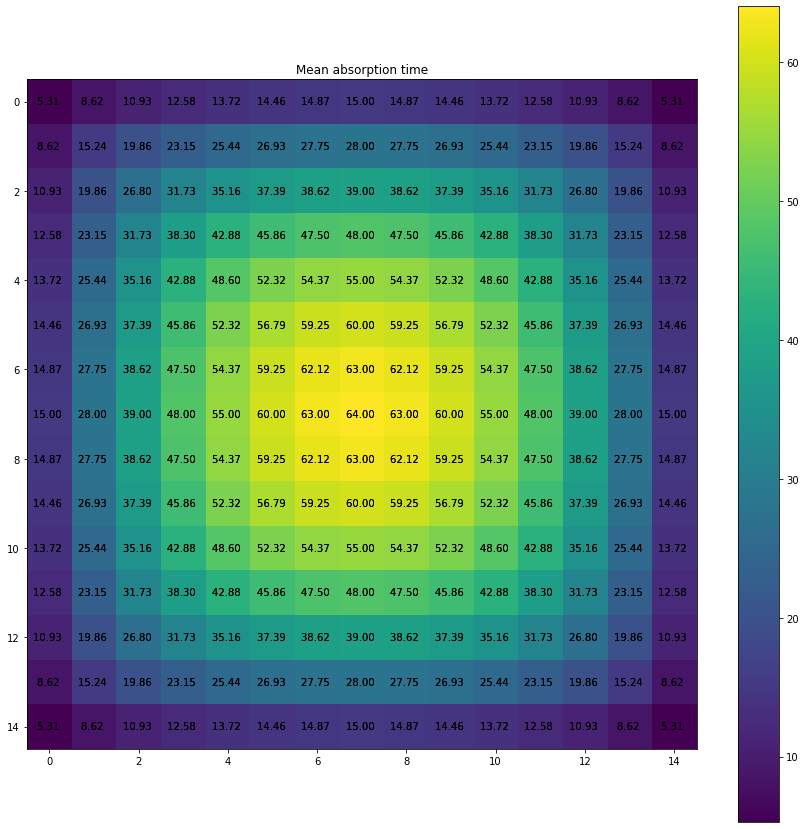

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
a = ax.imshow(np.reshape(vs, newshape=(inner_n, inner_n)))
fig.colorbar(a)
for (j, i), label in np.ndenumerate(np.reshape(vs, newshape=(inner_n, inner_n))):
    #print_str_1 = "↑→" if np.isclose(label, 1) else ""
    #print_str_2 = "↓←" if np.isclose(label, 0) else ""
    ax.text(i, j, f"{label:.2f} ", ha='center', va='center')
    ax.text(i, j, f"{label:.2f} ", ha='center', va='center')
    #print(label)
ax.set_title("Mean absorption time")

In [11]:
border_color_3 = np.array([204, 153, 255]) / 255.0
border_color_2 = np.array([178, 102, 255]) / 255.0
border_color_1 = np.array([141, 29, 255]) / 255.0
white_color = np.array([255, 255, 255]) / 255.0
center_color_1 = np.array([255, 202, 26]) / 255.0
center_color_2 = np.array([255, 219, 102]) / 255.0
center_color_3 = np.array([255, 231, 153]) / 255.0
rwgame_cmap = mcolors.LinearSegmentedColormap.from_list(
        'rwgame', [border_color_1, border_color_2, border_color_3, white_color, center_color_3, center_color_2, center_color_1])

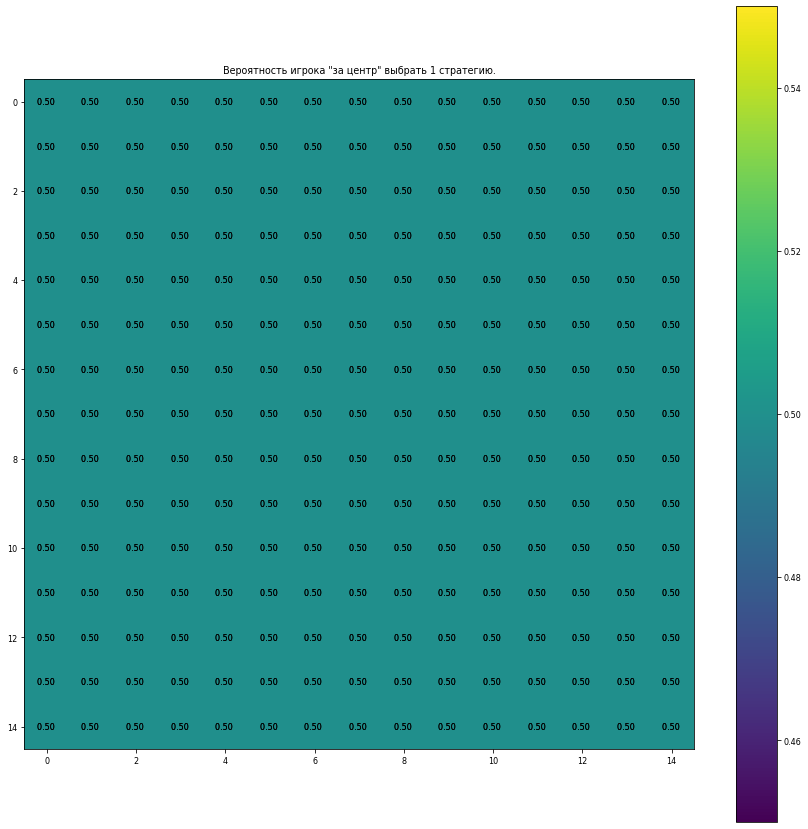

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
a = ax.imshow(np.reshape(p1s, newshape=(inner_n, inner_n)))
fig.colorbar(a)

for (j, i), label in np.ndenumerate(np.reshape(p1s, newshape=(inner_n, inner_n))):
    print_str_1 = "↑→" if np.isclose(label, 1) else ""
    print_str_2 = "↓←" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
ax.set_title("Вероятность игрока \"за центр\" выбрать 1 стратегию.")
fig.savefig("G:\Studies\Masters\img\\bvp_strategy.png")

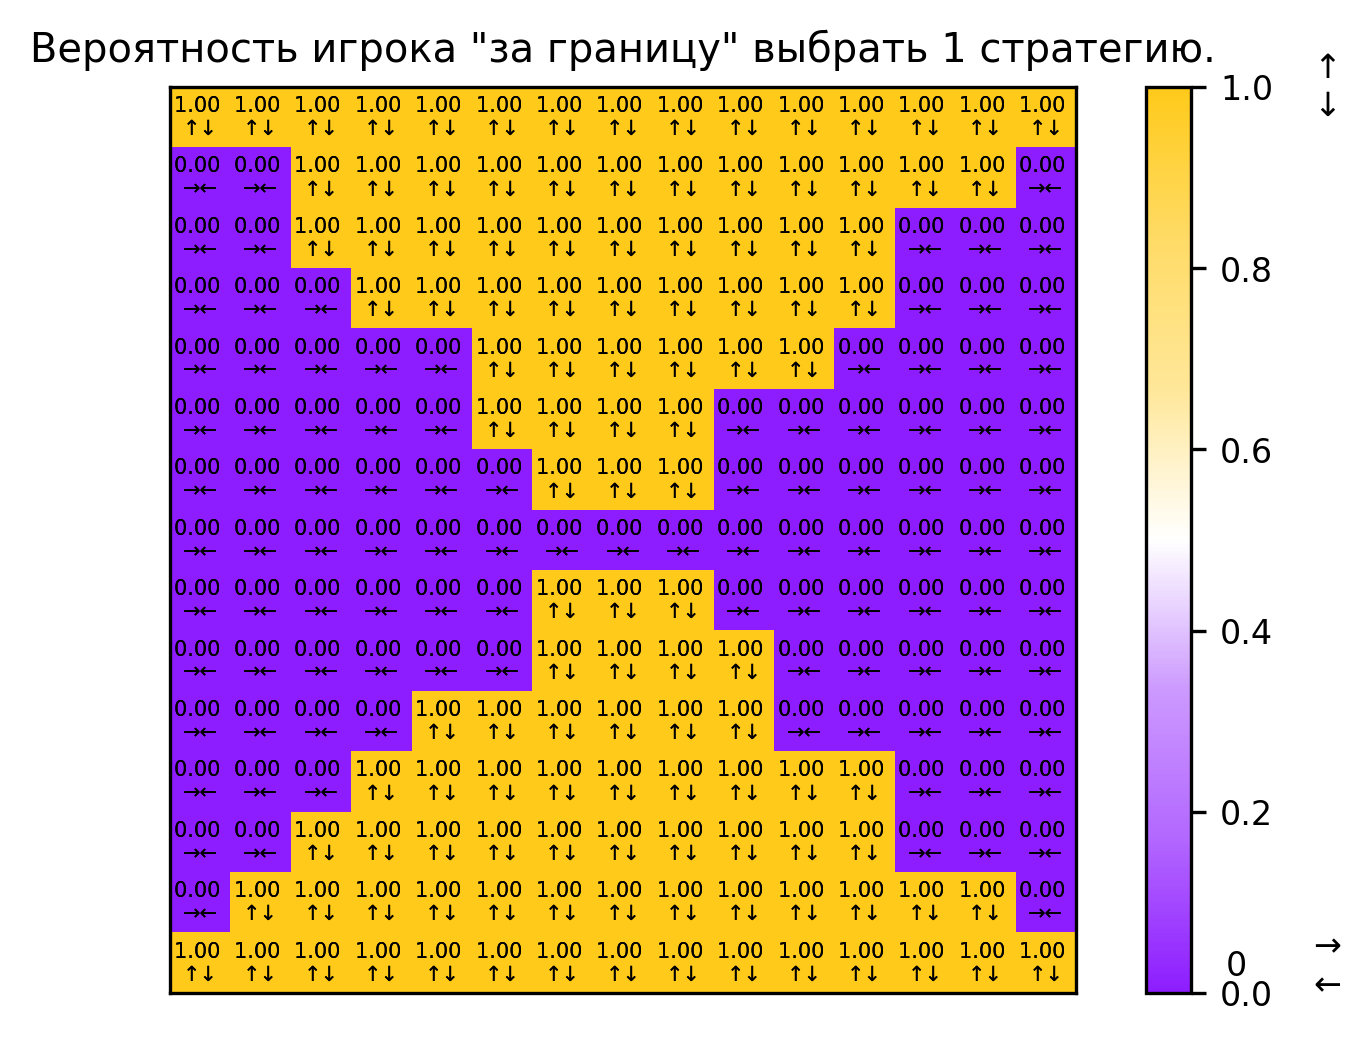

In [13]:
font = {'family' : 'normal',
        'size'   : 5}

mpl.rc('font', **font)

fig, ax = plt.subplots(1, 1, dpi=300)
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
a = ax.imshow(np.reshape(q1s, newshape=(inner_n, inner_n)), cmap=rwgame_cmap)


for (j, i), label in np.ndenumerate(np.reshape(q1s, newshape=(inner_n, inner_n))):
    print_str_1 = "\n↑↓" if np.isclose(label, 1) else ""
    print_str_2 = "\n→←" if np.isclose(label, 0) else ""
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
    plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')

font = {'family' : 'normal',
        'size'   : 8}
mpl.rc('font', **font)

cbar = fig.colorbar(a)
cbar.ax.text(4, 1, '↑\n↓', ha='center', va='center')
cbar.ax.text(2, 0.03, '0', ha='center', va='center')
cbar.ax.text(4, 0.03, '→\n←', ha='center', va='center')

ax.set_title("Вероятность игрока \"за границу\" выбрать 1 стратегию.")
fig.savefig("G:\Studies\Masters\img\\bvp_2_strategy.png")
